<a href="https://colab.research.google.com/github/akashsiddharth1/BrainTumor_classification/blob/main/Brain_Tumor_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BRAIN TUMOR CLASSIFICATION

In [3]:
pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 104.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 110.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 133.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 107.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.31.1
    Uninstalling protobuf-6.31.1:
      Successfully uninstalled protobuf-6.31.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11/11 [tensorflow]


In [2]:
pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.2 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [61]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import defaultdict
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50, MobileNetV2, InceptionV3, EfficientNetB0
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

Understand the Dataset


Review the number of categories (tumor types) and sample images.


Check for class imbalance and image resolution consistency.


Explore image distributions visually. **bold text**


In [31]:
data_dir = "/content/drive/MyDrive/Files/Tumour"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "valid")
test_dir = os.path.join(data_dir, "test")

classes = ['glioma', 'meningioma', 'pituitary', 'no_tumor']

In [32]:
# Check image counts per class
train_counts = {}
val_counts = {}
test_counts = {}
for cls in classes:
    train_counts[cls] = len(os.listdir(os.path.join(train_dir, cls)))
    val_counts[cls] = len(os.listdir(os.path.join(val_dir, cls)))
    test_counts[cls] = len(os.listdir(os.path.join(test_dir, cls)))
    print(f"{cls}: Train={train_counts[cls]}, Val={val_counts[cls]}, Test={test_counts[cls]}")

glioma: Train=564, Val=161, Test=80
meningioma: Train=358, Val=124, Test=63
pituitary: Train=438, Val=118, Test=54
no_tumor: Train=335, Val=99, Test=49


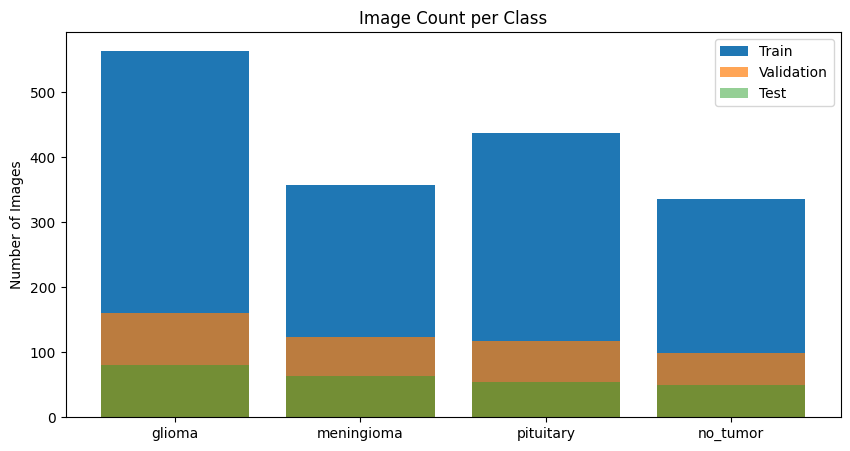

In [33]:
# Visualize class distribution
plt.figure(figsize=(10, 5))
plt.bar(train_counts.keys(), train_counts.values(), label='Train')
plt.bar(val_counts.keys(), val_counts.values(), label='Validation', alpha=0.7)
plt.bar(test_counts.keys(), test_counts.values(), label='Test', alpha=0.5)
plt.title("Image Count per Class")
plt.ylabel("Number of Images")
plt.legend()
plt.show()

In [34]:
# Check image resolution consistency
img_shapes = defaultdict(int)
for cls in classes:
    sample_dir = os.path.join(train_dir, cls)
    for img_name in os.listdir(sample_dir)[:50]:  # Sample 50 images
        img_path = os.path.join(sample_dir, img_name)
        try:
            img = Image.open(img_path)
            img_shapes[img.size] += 1
        except:
            continue

print("\nImage Resolution Distribution (from 50 samples per class):")
for shape, count in img_shapes.items():
    print(f"{shape}: {count} images")


Image Resolution Distribution (from 50 samples per class):
(640, 640): 200 images


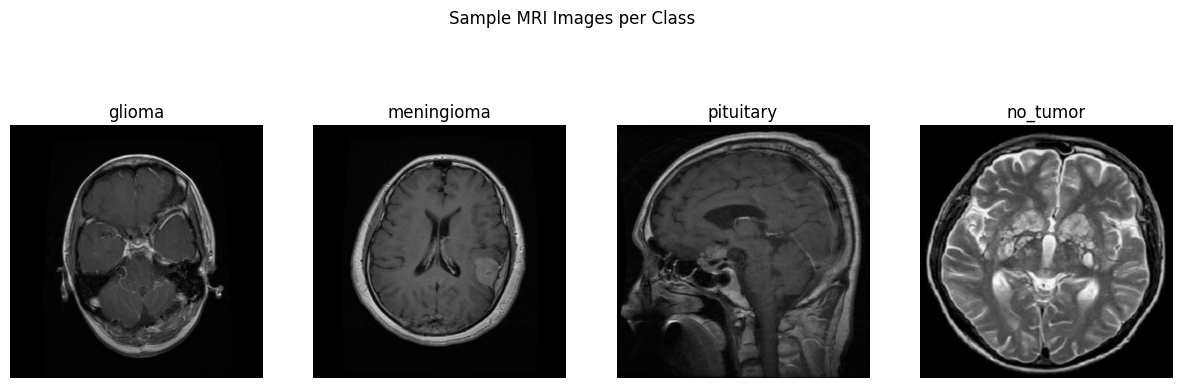

In [35]:
# Visualize sample images per class
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
for i, cls in enumerate(classes):
    sample_img_path = os.path.join(train_dir, cls, os.listdir(os.path.join(train_dir, cls))[0])
    img = Image.open(sample_img_path)
    axes[i].imshow(img)
    axes[i].set_title(cls)
    axes[i].axis('off')
plt.suptitle("Sample MRI Images per Class")
plt.show()

# Data Preprocessing


Normalize pixel values to a 0–1 range.


Resize images to a consistent shape suitable for model input (e.g. 224x224 pixels).


In [36]:
img_size = (224, 224)
batch_size = 64

# Normalize pixel values (0–1 range)
preprocess_datagen = ImageDataGenerator(rescale=1./255)

# Preprocessing for training, validation, and test sets
train_preproc = preprocess_datagen.flow_from_directory(train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
val_preproc = preprocess_datagen.flow_from_directory(val_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
test_preproc = preprocess_datagen.flow_from_directory(test_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)


Found 1695 images belonging to 4 classes.
Found 502 images belonging to 4 classes.
Found 246 images belonging to 4 classes.


# Data Augmentation


Apply transformations like rotation, horizontal/vertical flipping, zoom, brightness adjustments, and shifts to artificially increase training data and improve model generalization.


In [48]:
#Data Augmentation
augment_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.5,
    height_shift_range=0.5,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = augment_datagen.flow_from_directory(train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
val_generator = preprocess_datagen.flow_from_directory(val_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
test_generator = preprocess_datagen.flow_from_directory(test_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)


Found 1695 images belonging to 4 classes.
Found 502 images belonging to 4 classes.
Found 246 images belonging to 4 classes.


In [49]:
for cls, count in train_generator.class_indices.items():
    print(f"{cls}: {count}")


glioma: 0
meningioma: 1
no_tumor: 2
pituitary: 3


In [50]:
# Get class distribution
labels_count = train_generator.classes
unique, counts = np.unique(labels_count, return_counts=True)
print(dict(zip(train_generator.class_indices.keys(), counts)))


{'glioma': np.int64(564), 'meningioma': np.int64(358), 'no_tumor': np.int64(335), 'pituitary': np.int64(438)}


In [40]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels_count),
    y=labels_count
)
class_weights = dict(enumerate(class_weights))


# Model Building


Custom CNN: Design a convolutional neural network from scratch, selecting appropriate convolution, pooling, and dense layers.


Implement dropout and batch normalization layers to avoid overfitting and stabilize learning.


In [51]:
# Build custom CNN using explicit Input layer
def build_custom_cnn(input_shape=(224, 224, 3), num_classes=4):
    model = Sequential([
        Input(shape=input_shape),

        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(),
        BatchNormalization(),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(),
        BatchNormalization(),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dropout(0.5),

        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Create the model
custom_cnn = build_custom_cnn()

# Transfer Learning


Load pretrained models (Example : ResNet50, MobileNetV2, InceptionV3, EfficientNetB0) with ImageNet weights.


Replace the top classification layers with new dense layers suited for the tumor categories.


Optionally unfreeze top layers for fine-tuning after initial training.


In [52]:
# Generic function for transfer learning

def build_transfer_model(base_model_class, input_shape=(224, 224, 3), num_classes=4, fine_tune_at=None):
    base_model = base_model_class(weights='imagenet', include_top=False, input_shape=input_shape)

    if fine_tune_at:
        base_model.trainable = True
        for layer in base_model.layers[:-fine_tune_at]:
            layer.trainable = False
    else:
        base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    return Model(inputs=base_model.input, outputs=outputs)

In [53]:
# Instantiate models
resnet_model = build_transfer_model(ResNet50)
mobilenet_model = build_transfer_model(MobileNetV2)
inception_model = build_transfer_model(InceptionV3)
efficientnet_model = build_transfer_model(EfficientNetB0)

# Model Training


Train both custom CNN and transfer learning models.


Use callbacks like EarlyStopping and ModelCheckpoint to monitor validation loss and save the best performing models.


Track training and validation metrics.


In [54]:
# Training Function with Callbacks
def train_model(model, name):
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ModelCheckpoint(f"{name}.h5", monitor='val_accuracy', save_best_only=True)
    ]

    history = model.fit(
        train_generator,
        epochs=20,
        validation_data=val_generator,
        callbacks=callbacks,
        class_weight=class_weights

    )
    return history


In [55]:
# Train all models
custom_history = train_model(custom_cnn, "custom_cnn")
resnet_history = train_model(resnet_model, "resnet50")
mobilenet_history = train_model(mobilenet_model, "mobilenetv2")
inception_history = train_model(inception_model, "inceptionv3")
efficientnet_history = train_model(efficientnet_model, "efficientnetb0")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.2622 - loss: 10.7486

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/27 ━━━━━━━━━━━━━━━━━━━━ 255s 9s/step - accuracy: 0.2623 - loss: 10.5847 - val_accuracy: 0.1932 - val_loss: 1.3699
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.2285 - loss: 1.3522

27/27 ━━━━━━━━━━━━━━━━━━━━ 246s 9s/step - accuracy: 0.2302 - loss: 1.3518 - val_accuracy: 0.5578 - val_loss: 1.3372
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 247s 9s/step - accuracy: 0.3793 - loss: 1.3387 - val_accuracy: 0.4223 - val_loss: 1.3554
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 244s 9s/step - accuracy: 0.3972 - loss: 1.3239 - val_accuracy: 0.3845 - val_loss: 1.3540
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 245s 9s/step - accuracy: 0.3749 - loss: 1.3384 - val_accuracy: 0.3327 - val_loss: 1.3750
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 248s 9s/step - accuracy: 0.3604 - loss: 1.3453 - val_accuracy: 0.3406 - val_loss: 1.3681
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 244s 9s/step - accuracy: 0.4053 - loss: 1.3203 - val_accuracy: 0.3207 - val_loss: 1.3801
Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.2303 - loss: 1.6937 

27/27 ━━━━━━━━━━━━━━━━━━━━ 426s 16s/step - accuracy: 0.2307 - loss: 1.6913 - val_accuracy: 0.1892 - val_loss: 1.3682
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.2501 - loss: 1.4833 

27/27 ━━━━━━━━━━━━━━━━━━━━ 445s 16s/step - accuracy: 0.2508 - loss: 1.4819 - val_accuracy: 0.4024 - val_loss: 1.3246
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 417s 16s/step - accuracy: 0.2987 - loss: 1.4208 - val_accuracy: 0.2709 - val_loss: 1.3046
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 414s 16s/step - accuracy: 0.3320 - loss: 1.3481 - val_accuracy: 0.3426 - val_loss: 1.2846
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 477s 18s/step - accuracy: 0.3395 - loss: 1.3148 - val_accuracy: 0.3625 - val_loss: 1.2565
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.3541 - loss: 1.3089 

27/27 ━━━━━━━━━━━━━━━━━━━━ 477s 18s/step - accuracy: 0.3541 - loss: 1.3085 - val_accuracy: 0.4920 - val_loss: 1.2287
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 456s 16s/step - accuracy: 0.4048 - loss: 1.2957 - val_accuracy: 0.3386 - val_loss: 1.2705
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 417s 15s/step - accuracy: 0.3769 - loss: 1.2789 - val_accuracy: 0.3287 - val_loss: 1.2633
Epoch 9/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 474s 18s/step - accuracy: 0.3924 - loss: 1.2657 - val_accuracy: 0.2729 - val_loss: 1.3301
Epoch 10/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 473s 18s/step - accuracy: 0.4029 - loss: 1.2417 - val_accuracy: 0.4363 - val_loss: 1.2252
Epoch 11/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 426s 16s/step - accuracy: 0.4533 - loss: 1.2301 - val_accuracy: 0.3586 - val_loss: 1.2594
Epoch 12/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 467s 17s/step - accuracy: 0.4452 - loss: 1.2409 - val_accuracy: 0.3665 - val_loss: 1.2596
Epoch 13/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 426s 16s/step - accuracy: 0.4232 - loss: 1.2329 - val_accuracy: 0.4004 - 

27/27 ━━━━━━━━━━━━━━━━━━━━ 145s 5s/step - accuracy: 0.3669 - loss: 1.5748 - val_accuracy: 0.6514 - val_loss: 0.8107
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5763 - loss: 1.0468

27/27 ━━━━━━━━━━━━━━━━━━━━ 129s 5s/step - accuracy: 0.5772 - loss: 1.0446 - val_accuracy: 0.7112 - val_loss: 0.6560
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6576 - loss: 0.8213

27/27 ━━━━━━━━━━━━━━━━━━━━ 128s 5s/step - accuracy: 0.6582 - loss: 0.8209 - val_accuracy: 0.7351 - val_loss: 0.6407
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6852 - loss: 0.7814

27/27 ━━━━━━━━━━━━━━━━━━━━ 130s 5s/step - accuracy: 0.6859 - loss: 0.7799 - val_accuracy: 0.7968 - val_loss: 0.5377
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 153s 6s/step - accuracy: 0.7343 - loss: 0.6769 - val_accuracy: 0.7769 - val_loss: 0.5612
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 131s 5s/step - accuracy: 0.7532 - loss: 0.6598 - val_accuracy: 0.7928 - val_loss: 0.5248
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7522 - loss: 0.6506

27/27 ━━━━━━━━━━━━━━━━━━━━ 144s 5s/step - accuracy: 0.7522 - loss: 0.6506 - val_accuracy: 0.8227 - val_loss: 0.4965
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 144s 5s/step - accuracy: 0.7670 - loss: 0.6072 - val_accuracy: 0.7829 - val_loss: 0.5409
Epoch 9/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 152s 6s/step - accuracy: 0.7826 - loss: 0.5973 - val_accuracy: 0.8147 - val_loss: 0.4981
Epoch 10/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 128s 5s/step - accuracy: 0.7736 - loss: 0.5680 - val_accuracy: 0.7948 - val_loss: 0.5108
Epoch 11/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 133s 5s/step - accuracy: 0.8076 - loss: 0.5202 - val_accuracy: 0.8028 - val_loss: 0.4997
Epoch 12/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 144s 5s/step - accuracy: 0.8080 - loss: 0.5228 - val_accuracy: 0.7948 - val_loss: 0.5245
Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.3197 - loss: 1.7026

27/27 ━━━━━━━━━━━━━━━━━━━━ 316s 11s/step - accuracy: 0.3228 - loss: 1.6945 - val_accuracy: 0.6335 - val_loss: 0.9398
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.5636 - loss: 1.1528

27/27 ━━━━━━━━━━━━━━━━━━━━ 291s 11s/step - accuracy: 0.5643 - loss: 1.1507 - val_accuracy: 0.7112 - val_loss: 0.7199
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.6441 - loss: 0.9095

27/27 ━━━━━━━━━━━━━━━━━━━━ 296s 11s/step - accuracy: 0.6443 - loss: 0.9094 - val_accuracy: 0.7251 - val_loss: 0.6698
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.6461 - loss: 0.9354

27/27 ━━━━━━━━━━━━━━━━━━━━ 313s 12s/step - accuracy: 0.6470 - loss: 0.9338 - val_accuracy: 0.7649 - val_loss: 0.6191
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 318s 12s/step - accuracy: 0.7053 - loss: 0.7974 - val_accuracy: 0.7410 - val_loss: 0.6605
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7130 - loss: 0.7500

27/27 ━━━━━━━━━━━━━━━━━━━━ 316s 12s/step - accuracy: 0.7126 - loss: 0.7501 - val_accuracy: 0.7709 - val_loss: 0.5940
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7198 - loss: 0.7211

27/27 ━━━━━━━━━━━━━━━━━━━━ 316s 12s/step - accuracy: 0.7193 - loss: 0.7231 - val_accuracy: 0.7948 - val_loss: 0.5736
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 309s 12s/step - accuracy: 0.7251 - loss: 0.7284 - val_accuracy: 0.7888 - val_loss: 0.5614
Epoch 9/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7154 - loss: 0.7569

27/27 ━━━━━━━━━━━━━━━━━━━━ 316s 12s/step - accuracy: 0.7159 - loss: 0.7559 - val_accuracy: 0.7988 - val_loss: 0.5481
Epoch 10/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7202 - loss: 0.7070

27/27 ━━━━━━━━━━━━━━━━━━━━ 292s 11s/step - accuracy: 0.7204 - loss: 0.7073 - val_accuracy: 0.8147 - val_loss: 0.5192
Epoch 11/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 327s 11s/step - accuracy: 0.7097 - loss: 0.7197 - val_accuracy: 0.8028 - val_loss: 0.5340
Epoch 12/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 313s 12s/step - accuracy: 0.7272 - loss: 0.7191 - val_accuracy: 0.8127 - val_loss: 0.5003
Epoch 13/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 310s 12s/step - accuracy: 0.7480 - loss: 0.6846 - val_accuracy: 0.8147 - val_loss: 0.4948
Epoch 14/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7562 - loss: 0.6277

27/27 ━━━━━━━━━━━━━━━━━━━━ 310s 12s/step - accuracy: 0.7564 - loss: 0.6274 - val_accuracy: 0.8287 - val_loss: 0.5073
Epoch 15/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 298s 11s/step - accuracy: 0.7523 - loss: 0.6359 - val_accuracy: 0.8187 - val_loss: 0.4780
Epoch 16/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 288s 11s/step - accuracy: 0.7627 - loss: 0.6536 - val_accuracy: 0.8267 - val_loss: 0.5095
Epoch 17/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7584 - loss: 0.6382

27/27 ━━━━━━━━━━━━━━━━━━━━ 344s 12s/step - accuracy: 0.7586 - loss: 0.6379 - val_accuracy: 0.8367 - val_loss: 0.4645
Epoch 18/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 295s 11s/step - accuracy: 0.7658 - loss: 0.6165 - val_accuracy: 0.8207 - val_loss: 0.4744
Epoch 19/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 293s 11s/step - accuracy: 0.7642 - loss: 0.6438 - val_accuracy: 0.8287 - val_loss: 0.5011
Epoch 20/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 291s 11s/step - accuracy: 0.8046 - loss: 0.5636 - val_accuracy: 0.8307 - val_loss: 0.4738
Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2376 - loss: 1.4243

27/27 ━━━━━━━━━━━━━━━━━━━━ 226s 8s/step - accuracy: 0.2380 - loss: 1.4245 - val_accuracy: 0.3207 - val_loss: 1.3774
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 201s 7s/step - accuracy: 0.2224 - loss: 1.4261 - val_accuracy: 0.2351 - val_loss: 1.4028
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 202s 8s/step - accuracy: 0.2260 - loss: 1.4268 - val_accuracy: 0.2351 - val_loss: 1.3853
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 262s 7s/step - accuracy: 0.2590 - loss: 1.4097 - val_accuracy: 0.2351 - val_loss: 1.4024
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 203s 7s/step - accuracy: 0.2315 - loss: 1.4277 - val_accuracy: 0.2351 - val_loss: 1.4151
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 243s 9s/step - accuracy: 0.2429 - loss: 1.4021 - val_accuracy: 0.1972 - val_loss: 1.4091


# Model evaluation

In [59]:
def evaluate_model(model, test_generator, class_labels, model_name="Model"):
    print(f"=== Evaluation for {model_name} ===")

    # Predictions
    y_pred_probs = model.predict(test_generator)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = test_generator.classes

    # Metrics
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_labels))

 # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

    return {'Model': model_name, 'Accuracy': acc, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}

In [60]:
def plot_history(history, model_name="Model"):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Train Accuracy')
    plt.plot(epochs, val_acc, 'r*-', label='Val Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Train Loss')
    plt.plot(epochs, val_loss, 'r*-', label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Evaluation and plotting

=== Evaluation for Custom CNN ===


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 61s 19s/step
Accuracy : 0.5610
Precision: 0.4581
Recall   : 0.5610
F1 Score : 0.4965

Classification Report:

              precision    recall  f1-score   support

      glioma       0.78      0.85      0.81        80
  meningioma       0.47      0.48      0.47        63
    no_tumor       0.42      0.82      0.56        49
   pituitary       0.00      0.00      0.00        54

    accuracy                           0.56       246
   macro avg       0.42      0.54      0.46       246
weighted avg       0.46      0.56      0.50       246



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


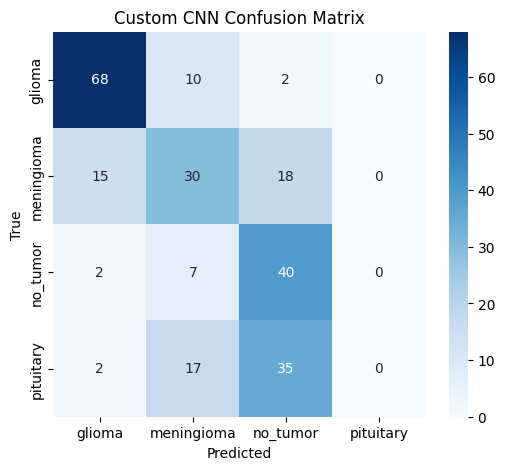

=== Evaluation for ResNet50 ===
4/4 ━━━━━━━━━━━━━━━━━━━━ 52s 12s/step
Accuracy : 0.4146
Precision: 0.5737
Recall   : 0.4146
F1 Score : 0.3933

Classification Report:

              precision    recall  f1-score   support

      glioma       0.71      0.38      0.49        80
  meningioma       0.80      0.13      0.22        63
    no_tumor       0.35      0.80      0.48        49
   pituitary       0.31      0.46      0.37        54

    accuracy                           0.41       246
   macro avg       0.54      0.44      0.39       246
weighted avg       0.57      0.41      0.39       246



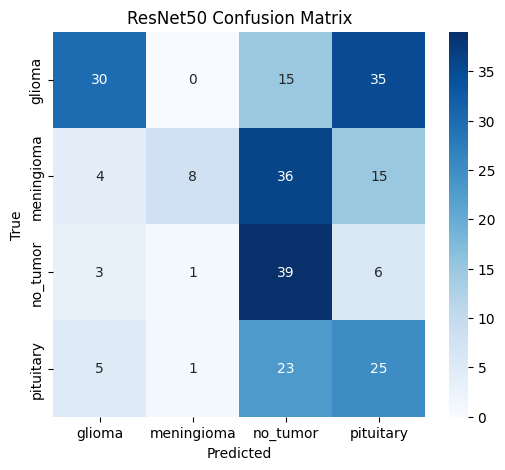

=== Evaluation for MobileNetV2 ===


3/4 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step
Accuracy : 0.7927
Precision: 0.8066
Recall   : 0.7927
F1 Score : 0.7852

Classification Report:

              precision    recall  f1-score   support

      glioma       0.91      0.84      0.87        80
  meningioma       0.80      0.52      0.63        63
    no_tumor       0.77      0.84      0.80        49
   pituitary       0.69      1.00      0.82        54

    accuracy                           0.79       246
   macro avg       0.79      0.80      0.78       246
weighted avg       0.81      0.79      0.79       246



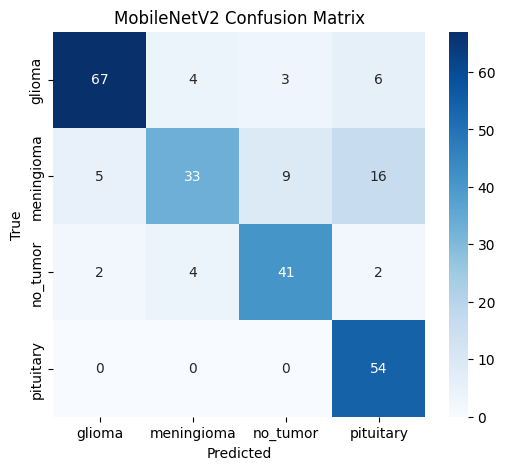

=== Evaluation for InceptionV3 ===
4/4 ━━━━━━━━━━━━━━━━━━━━ 40s 9s/step
Accuracy : 0.7724
Precision: 0.7769
Recall   : 0.7724
F1 Score : 0.7711

Classification Report:

              precision    recall  f1-score   support

      glioma       0.83      0.85      0.84        80
  meningioma       0.61      0.59      0.60        63
    no_tumor       0.92      0.73      0.82        49
   pituitary       0.77      0.91      0.83        54

    accuracy                           0.77       246
   macro avg       0.78      0.77      0.77       246
weighted avg       0.78      0.77      0.77       246



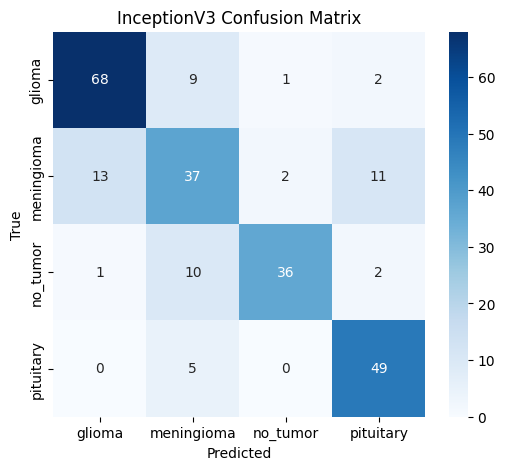

=== Evaluation for EfficientNetB0 ===
4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 6s/step
Accuracy : 0.3252
Precision: 0.1058
Recall   : 0.3252
F1 Score : 0.1596

Classification Report:

              precision    recall  f1-score   support

      glioma       0.33      1.00      0.49        80
  meningioma       0.00      0.00      0.00        63
    no_tumor       0.00      0.00      0.00        49
   pituitary       0.00      0.00      0.00        54

    accuracy                           0.33       246
   macro avg       0.08      0.25      0.12       246
weighted avg       0.11      0.33      0.16       246



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


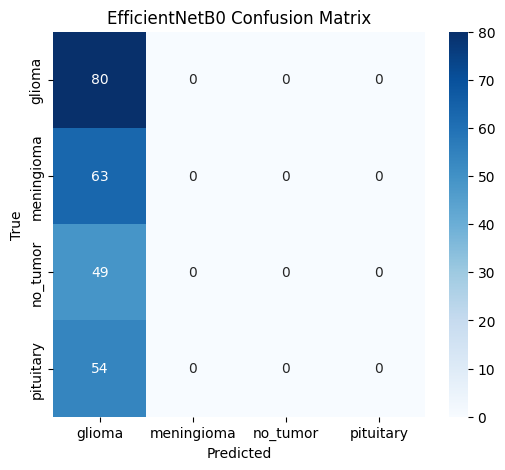

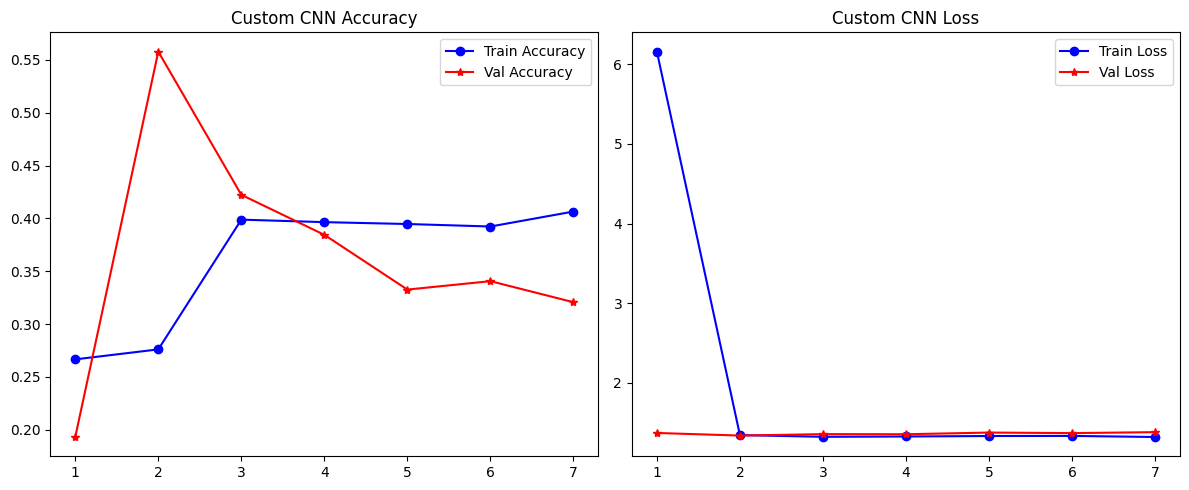

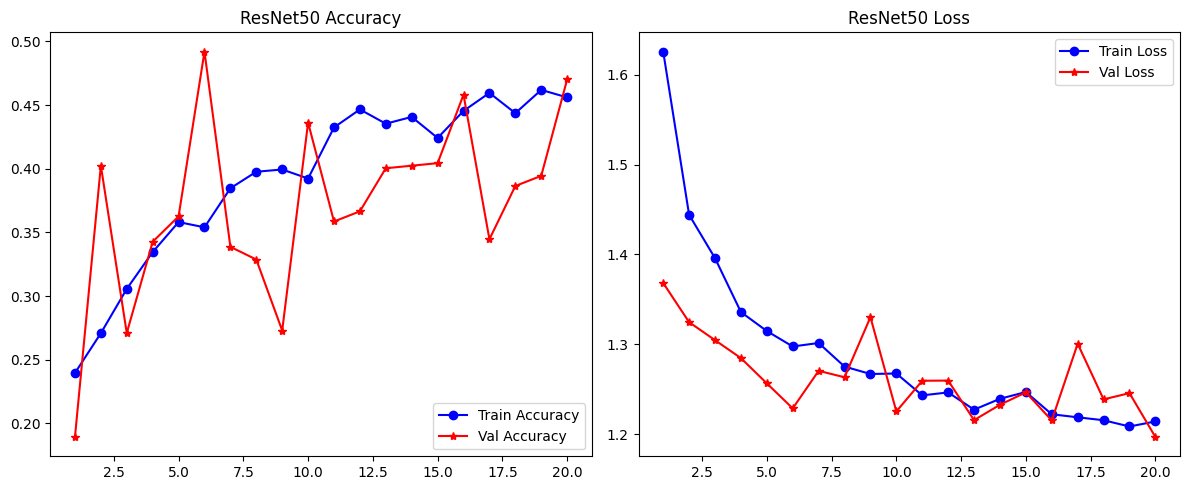

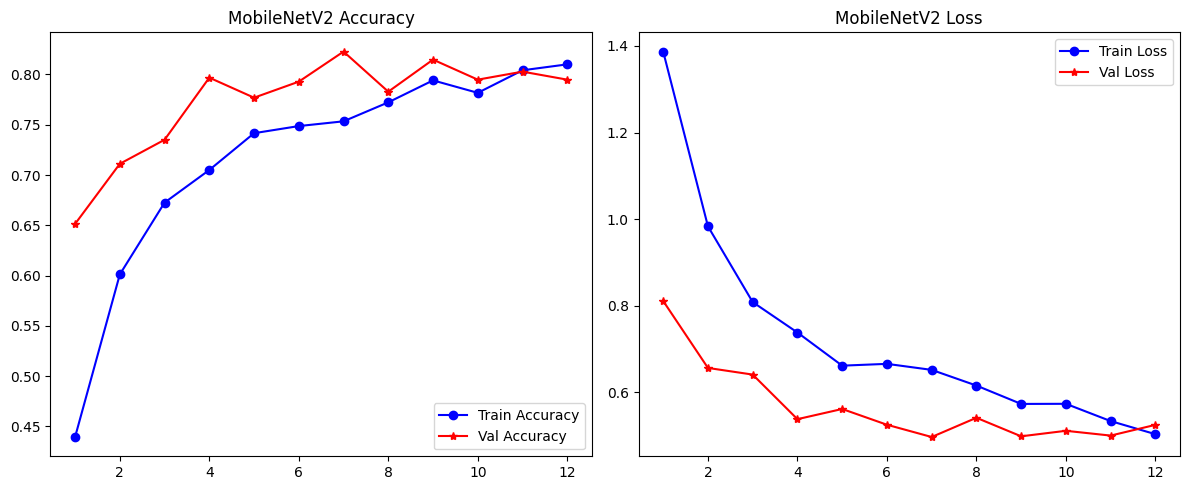

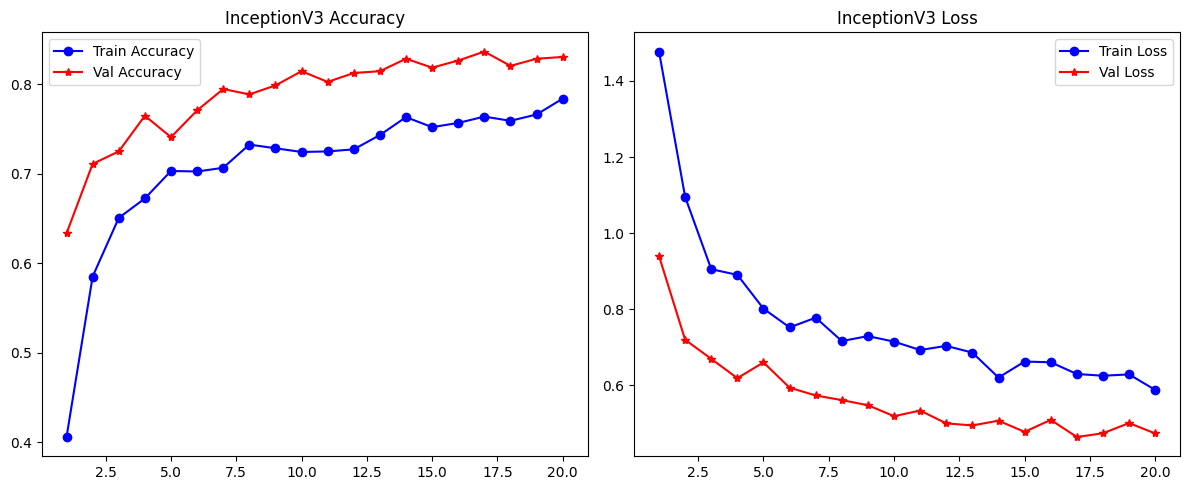

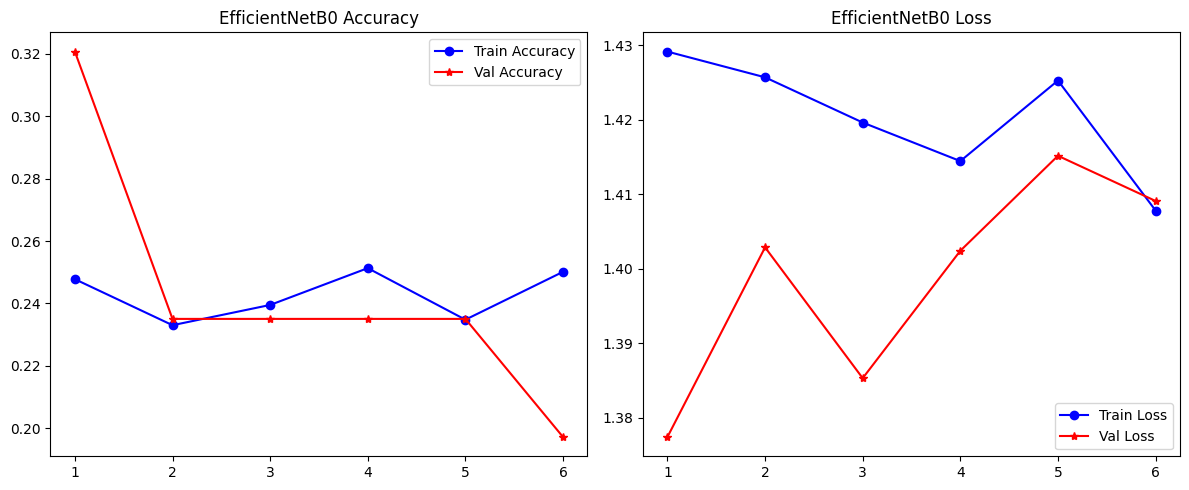

In [62]:
class_labels = list(test_generator.class_indices.keys())
evaluation_results = []

# Evaluate models
evaluation_results.append(evaluate_model(custom_cnn, test_generator, class_labels, "Custom CNN"))
evaluation_results.append(evaluate_model(resnet_model, test_generator, class_labels, "ResNet50"))
evaluation_results.append(evaluate_model(mobilenet_model, test_generator, class_labels, "MobileNetV2"))
evaluation_results.append(evaluate_model(inception_model, test_generator, class_labels, "InceptionV3"))
evaluation_results.append(evaluate_model(efficientnet_model, test_generator, class_labels, "EfficientNetB0"))

# Plot histories
plot_history(custom_history, "Custom CNN")
plot_history(resnet_history, "ResNet50")
plot_history(mobilenet_history, "MobileNetV2")
plot_history(inception_history, "InceptionV3")
plot_history(efficientnet_history, "EfficientNetB0")

# Model Comparison

In [64]:
import pandas as pd


In [65]:
# Create comparison table
comparison_df = pd.DataFrame(evaluation_results)
comparison_df = comparison_df.sort_values(by='F1 Score', ascending=False)
print("\n=== Model Comparison Table ===")
print(comparison_df)


=== Model Comparison Table ===
            Model  Accuracy  Precision    Recall  F1 Score
2     MobileNetV2  0.792683   0.806626  0.792683  0.785224
3     InceptionV3  0.772358   0.776948  0.772358  0.771120
0      Custom CNN  0.560976   0.458096  0.560976  0.496487
1        ResNet50  0.414634   0.573663  0.414634  0.393273
4  EfficientNetB0  0.325203   0.105757  0.325203  0.159609


In [66]:
# Find the best model based on F1 Score
best_model_name = comparison_df.iloc[0]['Model']
print(f"\n✅ Best Model Selected for Deployment: {best_model_name}")

# Map model name to actual model object
model_map = {
    'Custom CNN': custom_cnn,
    'ResNet50': resnet_model,
    'MobileNetV2': mobilenet_model,
    'InceptionV3': inception_model,
    'EfficientNetB0': efficientnet_model
}

best_model = model_map[best_model_name]


✅ Best Model Selected for Deployment: MobileNetV2


In [67]:
# Save model
best_model.save("best_brain_tumor_model.h5")
print("✅ Best model saved as 'best_brain_tumor_model.h5'")

# Save class indices
import pickle
with open("class_indices.pkl", "wb") as f:
    pickle.dump(test_generator.class_indices, f)
print("✅ Class indices saved as 'class_indices.pkl'")

✅ Best model saved as 'best_brain_tumor_model.h5'
✅ Class indices saved as 'class_indices.pkl'
